In [1]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# add RealSeries/realseries to sys path for import realseries
sys.path.append('..')
from realseries.models.iforest import IForest
from realseries.models.lumino import Lumino
from realseries.models.rcforest import RCForest
from realseries.utils.evaluation import point_metrics, adjust_predicts
from realseries.utils.data import load_split_NASA, load_splitted_RNN, load_NAB
from realseries.utils.visualize import plot_anom

In [2]:
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [3]:
# load and split data
# ----------------------------
dirname = 'realKnownCause'
filename = 'nyc_taxi.csv'

# the fraction of used for test
fraction=0.5

train_set, test_set = load_NAB(dirname, filename, fraction=fraction)

load data from /mnt/mfs/zhangxianrui/code/RealSeries/examples/data/NAB_data/realKnownCause/nyc_taxi.csv


In [4]:
# preview data head
print(train_set.head())

                       value  label
timestamp                          
2014-07-01 00:00:00  10844.0    0.0
2014-07-01 00:30:00   8127.0    0.0
2014-07-01 01:00:00   6210.0    0.0
2014-07-01 01:30:00   4656.0    0.0
2014-07-01 02:00:00   3820.0    0.0


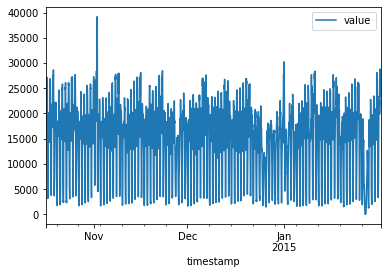

In [5]:
# the last column is label; other columns are values
train_data,train_label = train_set.iloc[:, :-1],train_set.iloc[:, -1]
test_data,test_label = test_set.iloc[:, :-1],test_set.iloc[:, -1]
test_data.plot()

In [6]:
# run rcforest method
# window_size
window_size = 40

# num_trees
num_trees=500

# tree_size
tree_size=1000
model = RCForest(
    shingle_size=window_size,
    num_trees=num_trees,
    tree_size=tree_size)

# X must be 1-D array
X = test_set.iloc[:,0]
score = model.detect(X)

precision:0.9999999980769231, recall:0.05024154588886555, f1:0.09567616382555821, tp:52, tn:4125, fp:0, fn:983


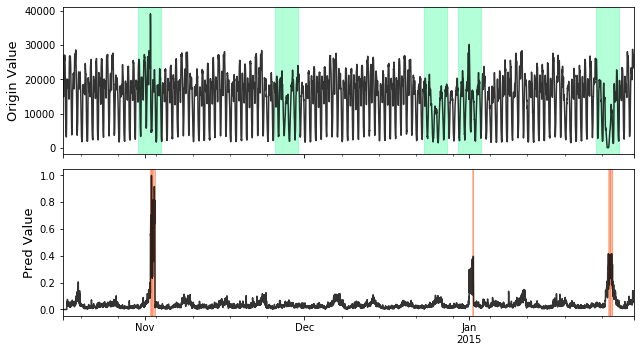

In [7]:
# the score value above thres_percent% is assigned anomaly point.
thres_percent=99
thres = np.percentile(score,thres_percent)
pred_label = (score>thres)

# visulaize the origin sequence and preditied results
plot_anom(
    test_set,
    pred_label,
    score)

# calc metrics by comparing pred_label and test_label
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

precision:0.9999999998389695, recall:0.5999999999420289, f1:0.7499999530344232, tp:621, tn:4125, fp:0, fn:414


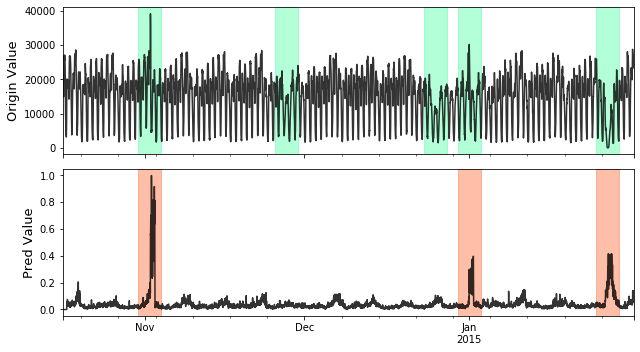

In [8]:
# adjust the pred_label for better visualization
adjust_pred_label = adjust_predicts(pred_label,test_label,delay=200)

# visualzie
plot_anom(
    test_set,
    adjust_pred_label,
    score)

# calculation metric
precision, recall, f1, tp, tn, fp, fn = point_metrics(adjust_pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

In [9]:
# train the isolation  forest model
# ------------------------
# number of trees
n_estimators=1000

# number of samples from the input array X for one estimator 
max_samples="auto"

# the fraction of anomaly point in the total input sequence
contamination=0.01

#random seed
random_state=0

#build model
IF = IForest(n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            random_state=random_state)

#train model
IF.fit(train_data)

In [10]:
# detect
score = IF.detect(test_data)

precision:0.6666666555555557, recall:0.0038647342991435037, f1:0.007684917200172527, tp:4, tn:4123, fp:2, fn:1031


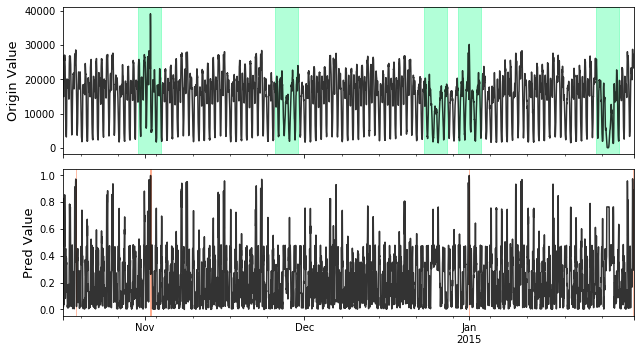

In [11]:
thres_percent=99.9
thres = np.percentile(score,thres_percent)
pred_label = (score>thres)

# visualization
plot_anom(
    test_set,
    pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

precision:0.9951923074530787, recall:0.3999999999613526, f1:0.5706408963054572, tp:414, tn:4123, fp:2, fn:621


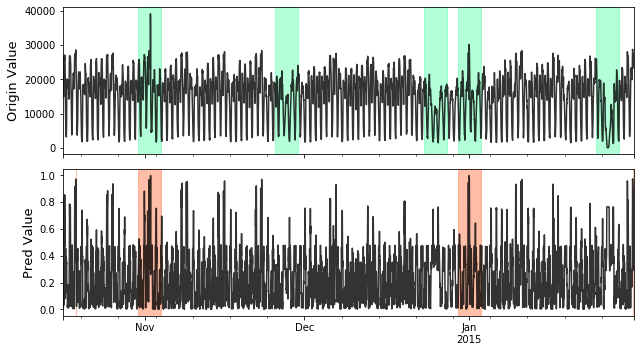

In [12]:
# adjust the pred_label for better visualization
adjust_pred_label = adjust_predicts(pred_label,test_label,delay=200)
plot_anom(
    test_set,
    adjust_pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(adjust_pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

In [13]:
# lumino model
model = Lumino()

# the input shape must be 1-D with shape (n, ) 
X = test_set.iloc[:,0]

# the dict containing all optioanl algorithms and params for luminol. 
algorithm_params = {'bitmap_detector':{'precision':5,
                      'lag_window_size':200,
                      'future_window_size':200,
                      'chunk_size':20},
    'derivative_detector':{'smoothing_factor':0.1},
    'exp_avg_detector':{'smoothing_factor':0.2,
                        'lag_window_size':50,
                        'use_lag_window': False}}      

precision:0.9999999833333336, recall:0.005797101448715256, f1:0.011527376373305524, tp:6, tn:4125, fp:0, fn:1029


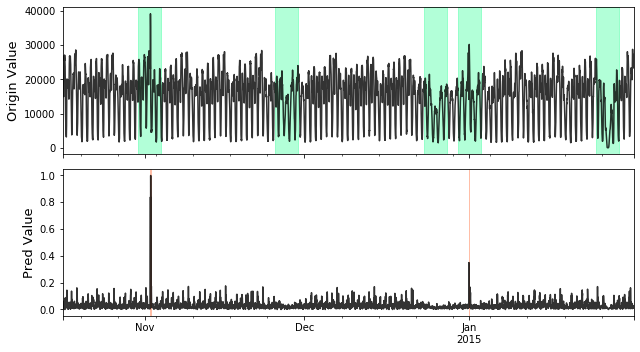

In [14]:
# algorithm_name
algorithm_name = 'exp_avg_detector'

# algorithm_param
algorithm_param = algorithm_params[algorithm_name]
score = model.detect(X,'default_detector')

# find thres
thres_percent=99.9
thres = np.percentile(score,thres_percent)
pred_label = (score>thres)

# visualization
plot_anom(
    test_set,
    pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

precision:0.9999999997584541, recall:0.3999999999613526, f1:0.5714285305333756, tp:414, tn:4125, fp:0, fn:621


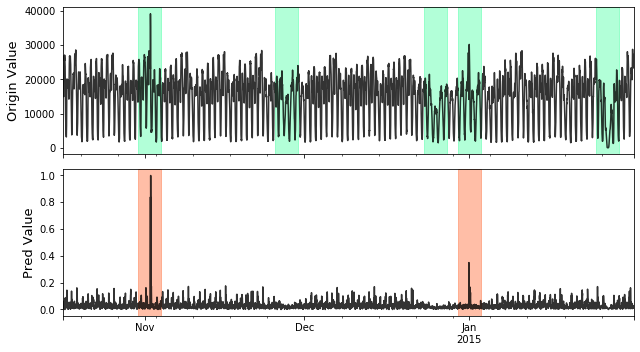

In [15]:
# adjust the pred_label for better visualization
adjust_pred_label = adjust_predicts(pred_label,test_label,delay=200)
plot_anom(
    test_set,
    adjust_pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(adjust_pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))